# Introduction
This is the code portion of the Udacity UD120 Introduction To Machine Learning MOOC.  The MOOC covers Algorithms (Naive Bayes, Support Vector Machine, Random Forest, AdaBoost, Word Tokenization), feature selection and validation.





In [327]:
import pickle
import sys
import pandas as pd
sys.path.append("../tools/")
from feature_format import featureFormat, targetFeatureSplit
data_dict = pickle.load(open("../final_project/final_project_dataset.pkl", "r") )
data_dict[data_dict.keys()[1]]

{'bonus': 1200000,
 'deferral_payments': 1295738,
 'deferred_income': -1386055,
 'director_fees': 'NaN',
 'email_address': 'NaN',
 'exercised_stock_options': 6680544,
 'expenses': 11200,
 'from_messages': 'NaN',
 'from_poi_to_this_person': 'NaN',
 'from_this_person_to_poi': 'NaN',
 'loan_advances': 'NaN',
 'long_term_incentive': 1586055,
 'other': 2660303,
 'poi': False,
 'restricted_stock': 3942714,
 'restricted_stock_deferred': 'NaN',
 'salary': 267102,
 'shared_receipt_with_poi': 'NaN',
 'to_messages': 'NaN',
 'total_payments': 5634343,
 'total_stock_value': 10623258}

# Data Exploration
total number of data points
allocation across classes (POI/non-POI)
number of features used
are there features with many missing values? etc.


In [2]:
#The first step is to take a look at the data provided.
#A couple issues pop out immediately: there are a large number of features, and many of the values will be missing
#We also have a relatively small number of records - 145 and 20 features to choose from
#Overfitting could be a problem
print(len(data_dict))
data_dict.items()[2]
#This last line is a spot check here to see that there are many missing values in the data.


146


('ELLIOTT STEVEN',
 {'bonus': 350000,
  'deferral_payments': 'NaN',
  'deferred_income': -400729,
  'director_fees': 'NaN',
  'email_address': 'steven.elliott@enron.com',
  'exercised_stock_options': 4890344,
  'expenses': 78552,
  'from_messages': 'NaN',
  'from_poi_to_this_person': 'NaN',
  'from_this_person_to_poi': 'NaN',
  'loan_advances': 'NaN',
  'long_term_incentive': 'NaN',
  'other': 12961,
  'poi': False,
  'restricted_stock': 1788391,
  'restricted_stock_deferred': 'NaN',
  'salary': 170941,
  'shared_receipt_with_poi': 'NaN',
  'to_messages': 'NaN',
  'total_payments': 211725,
  'total_stock_value': 6678735})

In [3]:
#Reformat data into an easier to use pandas data structure
df = pd.DataFrame.from_dict(data_dict,orient="index")
#Now answer some key questions about the data
#total number of data points
print 'Total number of people in data set: ', len(df.index)
print 'Total number of persons not of interest/of interest: ', df["poi"].value_counts()
print 'Number of features(including poi metric): ', len(df.columns.values)
#Next we will look for outliers and do any cleaning required

nan_count = 0
total_count = 0
for name, values in df.iteritems():
    for v in values:
        total_count += 1
        if v=='NaN': 
            nan_count += 1
print 'Total NaN points: ', nan_count
print 'Total count: ', total_count

Total number of people in data set:  146
Total number of persons not of interest/of interest:  False    128
True      18
Name: poi, dtype: int64
Number of features(including poi metric):  21
Total NaN points:  1358
Total count:  3066


In [4]:
#
#Missing value by label
#
for name, values in df.iteritems():
    nan_count =0
    for v in values:
        if v=='NaN': 
            nan_count += 1
    print name, ': ',nan_count

salary :  51
to_messages :  60
deferral_payments :  107
total_payments :  21
exercised_stock_options :  44
bonus :  64
restricted_stock :  36
shared_receipt_with_poi :  60
restricted_stock_deferred :  128
total_stock_value :  20
expenses :  51
loan_advances :  142
from_messages :  60
other :  53
from_this_person_to_poi :  60
poi :  0
director_fees :  129
deferred_income :  97
long_term_incentive :  80
email_address :  35
from_poi_to_this_person :  60


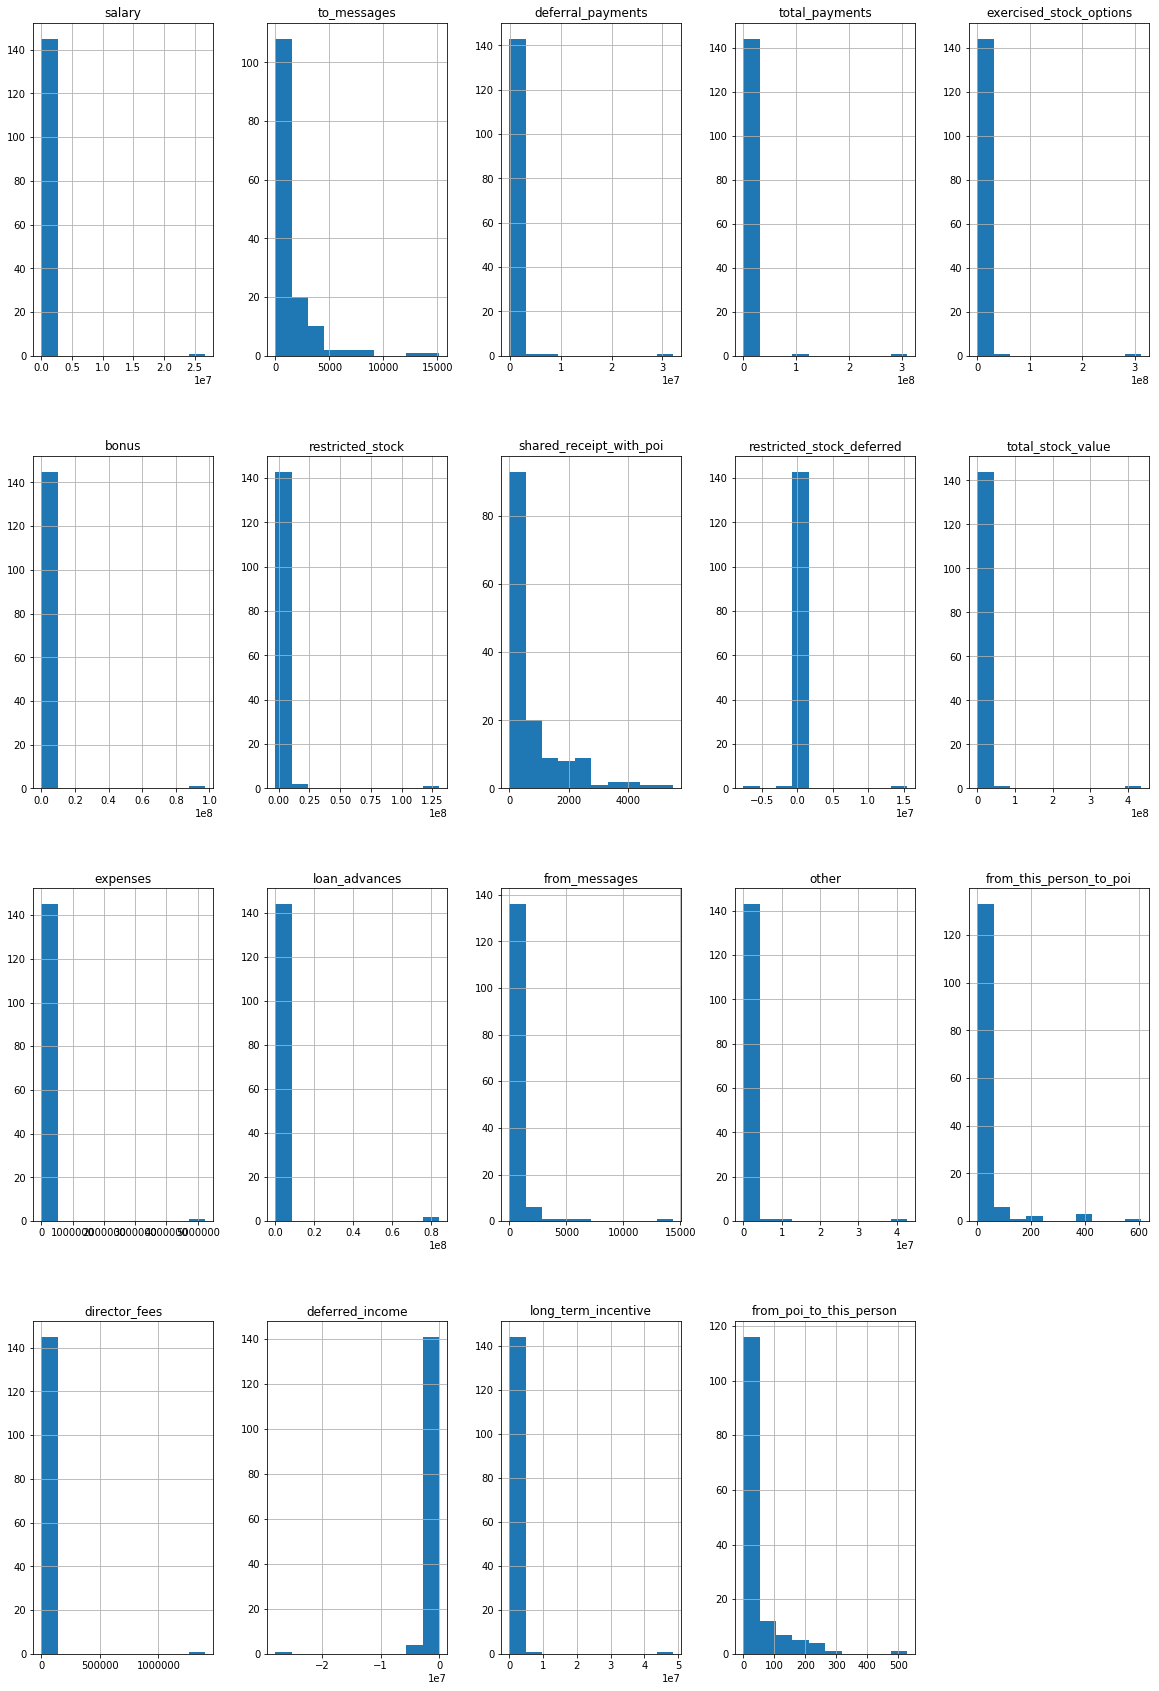

In [5]:
#Now we can look for outliers
#NaN values will be replaced with zero for the purposes of plotting only
import matplotlib.pyplot as plt
# multiple box plots on one figure
df_cleaned = df.replace(to_replace='NaN', value=0)
plt.clf()
plt.cla()
plt.close()
columns = ['salary', 'to_messages', 'deferral_payments', 'total_payments',
       'exercised_stock_options', 'bonus', 'restricted_stock',
       'shared_receipt_with_poi', 'restricted_stock_deferred',
       'total_stock_value', 'expenses', 'loan_advances', 'from_messages',
       'other', 'from_this_person_to_poi', 'director_fees',
       'deferred_income', 'long_term_incentive',
       'from_poi_to_this_person']
fig = plt.figure(figsize=(20, 30))
i=1
for column in columns:
    ax = fig.add_subplot(4, 5, i)
    #print(column)
    df_cleaned.hist(column=column,ax=ax)
    #plt.xticks(rotation=90)
    i+=1
plt.show()

## Data Exploration - Outliers
In this section there is a check for suspect values, either very large or very small.

Two things stand out:
1: There is a total column that should be removed
2: Ken Lay has financial metrics that are so far above everyone else that his record will cause problems if we choose a machine learning algorithm that is sensitive to outliers.  For now, Ken Lay will stay in.

In [6]:
#
# Check the high fliers
#
for column in columns:
    df_large = df_cleaned.nlargest(4,column)
    print column.ljust(30) ,': ',str(df_large.index.values).strip('[]')
    print column.ljust(30) ,': ',str(df_large[column].tolist()).strip('[]')

salary                         :  'TOTAL' 'SKILLING JEFFREY K' 'LAY KENNETH L' 'FREVERT MARK A'
salary                         :  26704229, 1111258, 1072321, 1060932
to_messages                    :  'SHAPIRO RICHARD S' 'KEAN STEVEN J' 'KITCHEN LOUISE' 'BELDEN TIMOTHY N'
to_messages                    :  15149, 12754, 8305, 7991
deferral_payments              :  'TOTAL' 'FREVERT MARK A' 'HORTON STANLEY C' 'HUMPHREY GENE E'
deferral_payments              :  32083396, 6426990, 3131860, 2964506
total_payments                 :  'TOTAL' 'LAY KENNETH L' 'FREVERT MARK A' 'BHATNAGAR SANJAY'
total_payments                 :  309886585, 103559793, 17252530, 15456290
exercised_stock_options        :  'TOTAL' 'LAY KENNETH L' 'HIRKO JOSEPH' 'RICE KENNETH D'
exercised_stock_options        :  311764000, 34348384, 30766064, 19794175
bonus                          :  'TOTAL' 'LAVORATO JOHN J' 'LAY KENNETH L' 'SKILLING JEFFREY K'
bonus                          :  97343619, 8000000, 7000000, 5600000
res

In [7]:
#
#Check for low fliers
#
for column in columns:
    df_small = df_cleaned.nsmallest(4,column)
    print column.ljust(30) ,': ',str(df_small.index.values).strip('[]')
    print column.ljust(30) ,': ',str(df_small[column].tolist()).strip('[]')

salary                         :  'BADUM JAMES P' 'BELFER ROBERT' 'BHATNAGAR SANJAY' 'BLAKE JR. NORMAN P'
salary                         :  0, 0, 0, 0
to_messages                    :  'BADUM JAMES P' 'BAXTER JOHN C' 'BAY FRANKLIN R' 'BAZELIDES PHILIP J'
to_messages                    :  0, 0, 0, 0
deferral_payments              :  'BELFER ROBERT' 'BANNANTINE JAMES M' 'BECK SALLY W' 'BERBERIAN DAVID'
deferral_payments              :  -102500, 0, 0, 0
total_payments                 :  'CHAN RONNIE' 'CHRISTODOULOU DIOMEDES' 'CLINE KENNETH W'
 'CORDES WILLIAM R'
total_payments                 :  0, 0, 0, 0
exercised_stock_options        :  'BAY FRANKLIN R' 'BECK SALLY W' 'BERGSIEKER RICHARD P'
 'BLAKE JR. NORMAN P'
exercised_stock_options        :  0, 0, 0, 0
bonus                          :  'BADUM JAMES P' 'BANNANTINE JAMES M' 'BAZELIDES PHILIP J' 'BELFER ROBERT'
bonus                          :  0, 0, 0, 0
restricted_stock               :  'BHATNAGAR SANJAY' 'BADUM JAMES P' 'BAZELIDES 

In [8]:
#
#Sanity check all names
#'THE TRAVEL AGENCY IN THE PARK' does not belong!
df.index.values


array(['ALLEN PHILLIP K', 'BADUM JAMES P', 'BANNANTINE JAMES M',
       'BAXTER JOHN C', 'BAY FRANKLIN R', 'BAZELIDES PHILIP J',
       'BECK SALLY W', 'BELDEN TIMOTHY N', 'BELFER ROBERT',
       'BERBERIAN DAVID', 'BERGSIEKER RICHARD P', 'BHATNAGAR SANJAY',
       'BIBI PHILIPPE A', 'BLACHMAN JEREMY M', 'BLAKE JR. NORMAN P',
       'BOWEN JR RAYMOND M', 'BROWN MICHAEL', 'BUCHANAN HAROLD G',
       'BUTTS ROBERT H', 'BUY RICHARD B', 'CALGER CHRISTOPHER F',
       'CARTER REBECCA C', 'CAUSEY RICHARD A', 'CHAN RONNIE',
       'CHRISTODOULOU DIOMEDES', 'CLINE KENNETH W', 'COLWELL WESLEY',
       'CORDES WILLIAM R', 'COX DAVID', 'CUMBERLAND MICHAEL S',
       'DEFFNER JOSEPH M', 'DELAINEY DAVID W', 'DERRICK JR. JAMES V',
       'DETMERING TIMOTHY J', 'DIETRICH JANET R', 'DIMICHELE RICHARD G',
       'DODSON KEITH', 'DONAHUE JR JEFFREY M', 'DUNCAN JOHN H',
       'DURAN WILLIAM D', 'ECHOLS JOHN B', 'ELLIOTT STEVEN',
       'FALLON JAMES B', 'FASTOW ANDREW S', 'FITZGERALD JAY L',
       'FOW

In [9]:
# Last step of the outlier investigation - create a cleaned data set without the totals included
df_clean = df.drop("TOTAL")
df_clean = df_clean.drop('THE TRAVEL AGENCY IN THE PARK')
df_clean

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,...,loan_advances,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,email_address,from_poi_to_this_person
ALLEN PHILLIP K,201955,2902,2869717,4484442,1729541,4175000,126027,1407,-126027,1729541,...,NaN,2195,152,65,False,NaN,-3081055,304805,phillip.allen@enron.com,47
BADUM JAMES P,NaN,NaN,178980,182466,257817,NaN,NaN,NaN,NaN,257817,...,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN
BANNANTINE JAMES M,477,566,NaN,916197,4046157,NaN,1757552,465,-560222,5243487,...,NaN,29,864523,0,False,NaN,-5104,NaN,james.bannantine@enron.com,39
BAXTER JOHN C,267102,NaN,1295738,5634343,6680544,1200000,3942714,NaN,NaN,10623258,...,NaN,NaN,2660303,NaN,False,NaN,-1386055,1586055,NaN,NaN
BAY FRANKLIN R,239671,NaN,260455,827696,NaN,400000,145796,NaN,-82782,63014,...,NaN,NaN,69,NaN,False,NaN,-201641,NaN,frank.bay@enron.com,NaN
BAZELIDES PHILIP J,80818,NaN,684694,860136,1599641,NaN,NaN,NaN,NaN,1599641,...,NaN,NaN,874,NaN,False,NaN,NaN,93750,NaN,NaN
BECK SALLY W,231330,7315,NaN,969068,NaN,700000,126027,2639,NaN,126027,...,NaN,4343,566,386,False,NaN,NaN,NaN,sally.beck@enron.com,144
BELDEN TIMOTHY N,213999,7991,2144013,5501630,953136,5249999,157569,5521,NaN,1110705,...,NaN,484,210698,108,True,NaN,-2334434,NaN,tim.belden@enron.com,228
BELFER ROBERT,NaN,NaN,-102500,102500,3285,NaN,NaN,NaN,44093,-44093,...,NaN,NaN,NaN,NaN,False,3285,NaN,NaN,NaN,NaN
BERBERIAN DAVID,216582,NaN,NaN,228474,1624396,NaN,869220,NaN,NaN,2493616,...,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,david.berberian@enron.com,NaN


# Feature Selection And Engineering
A first step is to balance the data out by adding multiples of each POI.  This will help prevent achieving a high accuracy score through always predicting a person is not a POI.

The next first step is to determine what to do with the missing data values.  Engineered features are added to flag missing values in each column, then the missing values in the original column are replaced with zeros.

For feature selection, univariate selection is used.
    

In [10]:
import numpy as np
df_selection = df_clean.copy()
new_columns = list(columns)
for column in columns:
    df_selection[column+'_IsMissing'] = np.where(df_selection[column]=='NaN', 1, 0)
    new_columns.append(column+'_IsMissing')
df_selection = df_selection.replace(to_replace='NaN', value=0)
#POI_data = df_selection.loc[df_clean['poi'] == True]
#6 copies will get close to 50-50 split
#df_selection_aug=df_selection.append(POI_data,ignore_index=True)
#df_selection_aug=df_selection_aug.append(POI_data,ignore_index=True)
#df_selection_aug=df_selection_aug.append(POI_data,ignore_index=True)
#df_selection_aug=df_selection_aug.append(POI_data,ignore_index=True)
#df_selection_aug=df_selection_aug.append(POI_data,ignore_index=True)
#df_selection_aug=df_selection_aug.append(POI_data,ignore_index=True)
#df_selection_aug.shape
df_selection.head()

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,...,total_stock_value_IsMissing,expenses_IsMissing,loan_advances_IsMissing,from_messages_IsMissing,other_IsMissing,from_this_person_to_poi_IsMissing,director_fees_IsMissing,deferred_income_IsMissing,long_term_incentive_IsMissing,from_poi_to_this_person_IsMissing
ALLEN PHILLIP K,201955,2902,2869717,4484442,1729541,4175000,126027,1407,-126027,1729541,...,0,0,1,0,0,0,1,0,0,0
BADUM JAMES P,0,0,178980,182466,257817,0,0,0,0,257817,...,0,0,1,1,1,1,1,1,1,1
BANNANTINE JAMES M,477,566,0,916197,4046157,0,1757552,465,-560222,5243487,...,0,0,1,0,0,0,1,0,1,0
BAXTER JOHN C,267102,0,1295738,5634343,6680544,1200000,3942714,0,0,10623258,...,0,0,1,1,0,1,1,0,0,1
BAY FRANKLIN R,239671,0,260455,827696,0,400000,145796,0,-82782,63014,...,0,0,1,1,0,1,1,0,1,1


In [11]:
#Univariate feature selection
# This next one is based on linear regression, so the presence of outiers like Ken Lay may be a problem
#
from sklearn.feature_selection import SelectPercentile, f_classif
Labels = df_selection["poi"].values
Features = df_selection[new_columns].values
selector = SelectPercentile(f_classif)
selector.fit(Features,Labels)
importances = selector.pvalues_
order = np.argsort(importances)
for i in order:
    print importances[i],new_columns[i]


1.59454384636e-06 exercised_stock_options
2.10580664901e-06 total_stock_value
9.70247434123e-06 bonus
3.03379610753e-05 salary
0.000454828852105 other_IsMissing
0.0008254654141 expenses_IsMissing
0.00085980314392 deferred_income
0.00184543514661 long_term_incentive
0.00265163145541 bonus_IsMissing
0.00266996113932 restricted_stock
0.003403426653 total_payments
0.00363440202436 shared_receipt_with_poi
0.00523055321107 salary_IsMissing
0.00729417704421 deferred_income_IsMissing
0.00797381626057 loan_advances
0.0136731508754 expenses
0.0222207279608 from_poi_to_this_person
0.0411643516562 other
0.0478154062078 restricted_stock_IsMissing
0.0502053203569 long_term_incentive_IsMissing
0.0615896650858 total_payments_IsMissing
0.0779822264099 total_stock_value_IsMissing
0.0962596265407 from_poi_to_this_person_IsMissing
0.0962596265407 to_messages_IsMissing
0.0962596265407 from_this_person_to_poi_IsMissing
0.0962596265407 from_messages_IsMissing
0.0962596265407 shared_receipt_with_poi_IsMissing

In [12]:
#More that 3 features was found to cause overfitting
selected_features_univariate = ['exercised_stock_options','total_stock_value','bonus']

In [13]:
#
#Try the same thing with a decision tree and recursive feature elimination
from sklearn.feature_selection import RFE
from sklearn import tree
clf = tree.DecisionTreeClassifier(min_samples_split=2)
rfe = RFE(estimator=clf, n_features_to_select=1, step=1)
rfe.fit(Features, Labels)
rfe.ranking_
for i in range(0,len(rfe.ranking_)):
    print rfe.ranking_[i],new_columns[i]

38 salary
37 to_messages
36 deferral_payments
3 total_payments
2 exercised_stock_options
4 bonus
5 restricted_stock
9 shared_receipt_with_poi
16 restricted_stock_deferred
15 total_stock_value
1 expenses
18 loan_advances
6 from_messages
8 other
7 from_this_person_to_poi
26 director_fees
28 deferred_income
30 long_term_incentive
32 from_poi_to_this_person
34 salary_IsMissing
35 to_messages_IsMissing
33 deferral_payments_IsMissing
31 total_payments_IsMissing
29 exercised_stock_options_IsMissing
27 bonus_IsMissing
25 restricted_stock_IsMissing
14 shared_receipt_with_poi_IsMissing
13 restricted_stock_deferred_IsMissing
12 total_stock_value_IsMissing
11 expenses_IsMissing
10 loan_advances_IsMissing
17 from_messages_IsMissing
19 other_IsMissing
20 from_this_person_to_poi_IsMissing
21 director_fees_IsMissing
22 deferred_income_IsMissing
23 long_term_incentive_IsMissing
24 from_poi_to_this_person_IsMissing


In [14]:
#More that 3 features was found to cause overfitting
selected_features_multivariate = ['exercised_stock_options','restricted_stock','total_payments']

In [15]:
#
# One more time using feature importances are repprted by a Random forest classifier
#Results are unstable
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
clf.fit(Features, Labels)
clf.feature_importances_
for i in range(0,len(clf.feature_importances_)):
    print clf.feature_importances_[i],new_columns[i]

0.0290122201394 salary
0.0376467986448 to_messages
0.00126315789474 deferral_payments
0.0401382521162 total_payments
0.127099456518 exercised_stock_options
0.068699443071 bonus
0.086909141826 restricted_stock
0.0877851483261 shared_receipt_with_poi
0.0131559942697 restricted_stock_deferred
0.0761599146017 total_stock_value
0.0623710563236 expenses
0.0 loan_advances
0.0377896651815 from_messages
0.0464779335777 other
0.052128204993 from_this_person_to_poi
0.0 director_fees
0.0871950994772 deferred_income
0.0180738744015 long_term_incentive
0.0385480780981 from_poi_to_this_person
0.0 salary_IsMissing
0.00432404605263 to_messages_IsMissing
0.00224243752925 deferral_payments_IsMissing
0.0 total_payments_IsMissing
0.0124667064202 exercised_stock_options_IsMissing
0.00971429053217 bonus_IsMissing
0.0 restricted_stock_IsMissing
0.0 shared_receipt_with_poi_IsMissing
0.00909473684211 restricted_stock_deferred_IsMissing
0.0 total_stock_value_IsMissing
0.00413277204176 expenses_IsMissing
0.0 loan

In [16]:
#More that 3 features was found to cause overfitting
selected_features_rf = ['expenses','exercised_stock_options','bonus']

In [17]:
#
#Let's add one more for fun.  This is based on human intuition that money and communication are key
#The total number of features needs to be kept low to prevent overfitting
#
#
selected_features_human= ['exercised_stock_options','expenses','from_this_person_to_poi']
selected_features_human_plus = ['exercised_stock_options','restricted_stock','total_payments','from_this_person_to_poi']

# Algorithm selection and tuning
Two common algorithms will be optimized and the best selected

A decision tree will be used - this does not require feature scaling, but will not be negatively impacted by scaling.

An SVM will be used.  It does require feature scaling.

Both algorithms will be tested on scaled data.


In [309]:
#
# Try the next few cells with different classifiers and features
#
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
#clf = GaussianNB()
clf = tree.DecisionTreeClassifier(min_samples_split=5)
test_features = selected_features_rf
#For tuning
parameters = {}
#parameters = {'min_samples_split':[2,5,10,20,40,80]} 
#parameters = {'min_samples_split':[2,5,10,20,40,80], 'min_samples_leaf':[2,5,10,20,40,80]}
#selected_features_rf = ['expenses','exercised_stock_options','bonus']
#selected_features_univariate = ['exercised_stock_options','total_stock_value','bonus']
#selected_features_multivariate = ['exercised_stock_options','restricted_stock','total_payments']
#selected_features_human= ['exercised_stock_options','expenses','from_this_person_to_poi']
#selected_features_human_plus = ['exercised_stock_options','restricted_stock','total_payments','from_this_person_to_poi'

In [310]:

from sklearn.preprocessing import MinMaxScaler

Labels = df_selection["poi"].values
Features = df_selection[test_features].values

#Scale
scaler = MinMaxScaler()
scaler.fit(Features)
Features - scaler.transform(Features)


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Features, Labels, test_size=0.3, random_state=42)
clf.fit(X_train,y_train)


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [311]:
#Quick test of the classifier
from sklearn.metrics import accuracy_score
predictions_test = clf.predict(X_test)
predictions_train = clf.predict(X_train)
print 'Test set: ',accuracy_score(predictions_test,y_test)
print 'Train set: ',accuracy_score(predictions_train,y_train)

Test set:  0.795454545455
Train set:  0.98


In [312]:
#Optimization
#Optimization can be performed on the entire data set
from sklearn.model_selection import GridSearchCV
optimizer = GridSearchCV(clf, parameters,return_train_score=False)
optimizer.fit(Features, Labels)
optimizer.best_params_

{}

In [313]:
#We now have the following feature sets, tuning parameters, and test-set accuracy scores (tree, GNB)
#selected_features_rf {'min_samples_split': 5} 0.8409, 0.8181
#selected_features_univariate {'min_samples_split': 5} 0.8181, 0.8181
#selected_features_multivariate {'min_samples_split': 80} 0.8181, 0.7954
#selected_features_human {'min_samples_split': 80} 0.0, 0.909
#selected_features_human_plus {'min_samples_split': 80} 0.8181, 0.7954

# Algorithm Validation
In this section we will evaluate precision and recall using the included test script provided by Udacity.


In [314]:
import tester as ud120test
import feature_format as ff

In [315]:
labels_save = list(test_features)
labels_save.insert(0,'poi')
print(labels_save)
ud120test.dump_classifier_and_data(clf, df_selection[labels_save].to_dict(orient='index'), labels_save)

['poi', 'expenses', 'exercised_stock_options', 'bonus']


In [316]:
ud120test.main()

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
	Accuracy: 0.82636	Precision: 0.39100	Recall: 0.38650	F1: 0.38874	F2: 0.38739
	Total predictions: 14000	True positives:  773	False positives: 1204	False negatives: 1227	True negatives: 10796



In [317]:
#We now have the following feature sets, tuning parameters, and test-set accuracy scores (train, test) (precision,recall)
#selected_features_rf dt {'min_samples_split': 5} (0.8409, 0.8181) (.39223, .3850)
#selected_features_rf nb (0.8638, 0.860) (0.482, 0.28850)
#selected_features_univariate dt {'min_samples_split': 5} (0.8181, 0.8181) (0.35564,0.33771)
#selected_features_univariate nb (0.886 0.87) (0.48581, 0.351)
#selected_features_multivariate dt {'min_samples_split': 80} (0.8181, 0.7954) (0.75244, 0.19300)
#selected_features_multivariate nb (0.87 0.8636) (0.387, 0.179)
#selected_features_human dt {'min_samples_split': 80} (0.90, 0.909) (0.75966, 0.177)
#selected_features_human nb (0.87 0.909) (0.56397 0.2755)

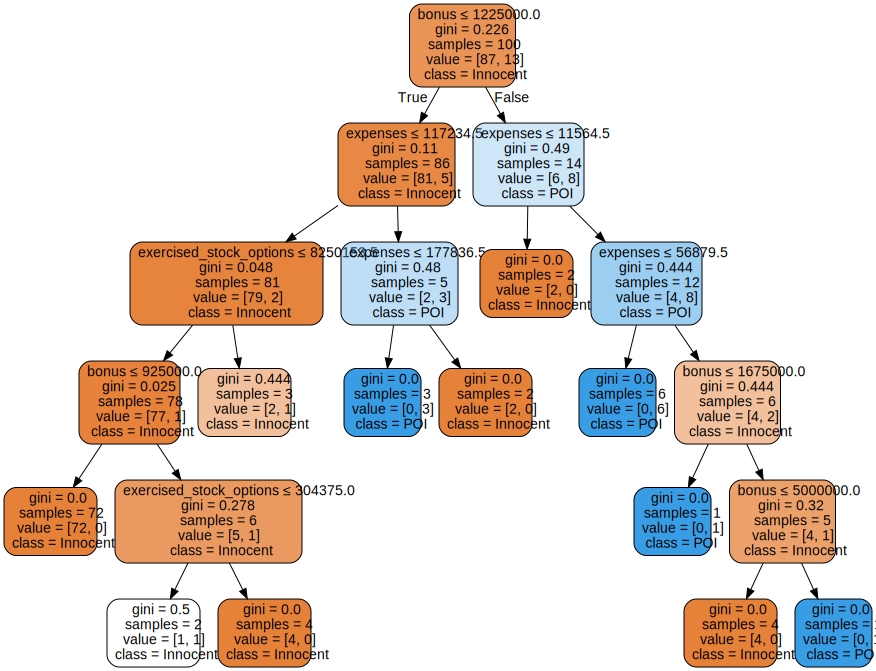

In [318]:
import graphviz 
dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=test_features,  
                         class_names=[ 'Innocent','POI'],  
                         filled=True, rounded=True,  
                         special_characters=True) 
graph = graphviz.Source(dot_data) 
graphviz.Source(dot_data)  
graph 